In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
import numpy as np

data = Path("data")

# Style transfer

Components of neural style transfer : 
- Pretrained object detection network to create feature maps
- Definition of content loss and style loss

Feature responses in higher levels of the network = content representation.

Correlation between different filter responses = style representation.

In [159]:
# Pretrained network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# VGG input images are normalized 
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1, 1, 1)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1, 1, 1)

# Check which layers are convolutional layers
index = 0
conv_layer_indices = []

for module in cnn:
    if isinstance(module, nn.modules.conv.Conv2d):
        conv_layer_indices.append(index)
    index+=1
    
print("The model has conv layers at following indices :\n", conv_layer_indices)

The model has conv layers at following indices :
 [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]


# Content image

Given a **content image $p$** and a generated **white noise image $x$**, we examine the feature maps generated by the different convolutional layers of the pre-trained network VGG19. For the layer $l$, we denote $N_l$ the number of feature maps and $M_l$ their size (height $*$ weigth of the feature map). Thus, the responses of the layer $l$ for the image $P$ can be stored in a $N_l * M_l$ matrix $P^l$ where $P^l_{ij}$ is the activation of the $i^{th}$ filter at position $j$ in layer $l$. This matrix is referred to as the feature representation of the input image at layer $l$.

Given $P^l$ and $F^l$, the feature representations of respectively $p$ and $x$, the content loss is defined as $\frac{1}{2}\sum_{i,j}(F^l_{ij} - P^l_{ij})^2$.

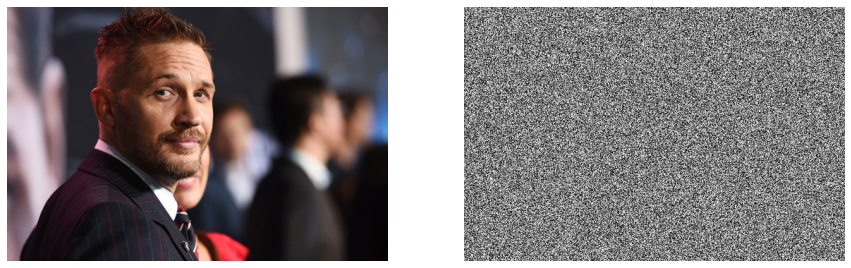

In [27]:
# Get content image and downsize it
content_img = Image.open(Path(data, "content.jpg")).convert('RGB')
w, h = content_img.size
content_img = content_img.resize((int(w/3), int(h/3)))
w, h = content_img.size

# Create random noise image of same dimensions
noise = np.zeros((h, w, 3), 'uint8')
random_matrix = np.random.randint(0, 255, size = (h, w)).astype(np.uint8)
noise[...,0] = noise[...,1] = noise[...,2] = random_matrix
content_noise = Image.fromarray(noise)# .save(path)

# Visualize
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(content_img)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(content_noise)
plt.show()

In [184]:
# Get tensors
content_img_tensor = transforms.ToTensor()(content_img).unsqueeze(0) # unsqueeze adds batch dimension
content_noise_tensor = transforms.ToTensor()(content_noise).unsqueeze(0)

# Normalize
content_img_tensor = (content_img_tensor - cnn_normalization_mean) / cnn_normalization_std
content_noise_tensor = (content_noise_tensor - cnn_normalization_mean) / cnn_normalization_std

# Get subsection of network with conv layer outputs
sub_cnn = cnn[:6]
print(sub_cnn)

# Define process to update the noise image untill it matches the feature response
learning_rate = 500
for iteration in range(1000):
    
    # Track grad again
    content_noise_tensor.requires_grad = True
    
    #  Get feature responses
    reference_response = sub_cnn(content_img_tensor)
    current_response = sub_cnn(content_noise_tensor)
    
    # Content loss
    loss = F.mse_loss(current_response, reference_response)
    loss.backward()
    
    if iteration % 100 == 0:
        print(f"Iteration {iteration}: content loss = {loss.item()}")
    
    with torch.no_grad():
        content_noise_tensor = content_noise_tensor - learning_rate * content_noise_tensor.grad
    
    # Zero grad
    content_noise_tensor.grad = None
    
print(f"Final loss = {loss.item()}")

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Iteration 0: content loss = 359.14599609375
Iteration 100: content loss = 1.1702966690063477
Iteration 200: content loss = 0.8329483270645142
Iteration 300: content loss = 0.701566219329834
Iteration 400: content loss = 0.6352750062942505
Iteration 500: content loss = 0.5846169590950012
Iteration 600: content loss = 0.5526953339576721
Iteration 700: content loss = 0.5339076519012451
Iteration 800: content loss = 0.4895882308483124
Iteration 900: content loss = 0.423290491104126
Final loss = 0.43713808059692383


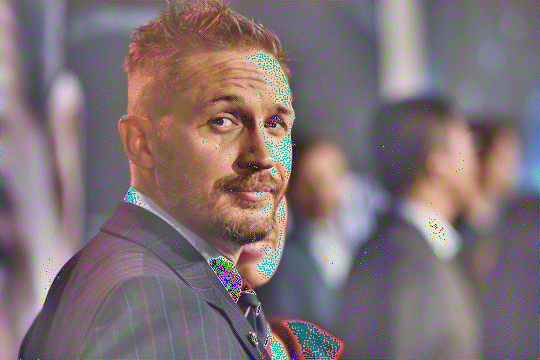

In [185]:
# Conv 3 : 1000 iterations with learning rate = 500, final loss = 4e-3
res = transforms.ToPILImage()((content_noise_tensor * cnn_normalization_std + cnn_normalization_mean).squeeze(0))
res.save("data/conv3_reconstruction.png")
res

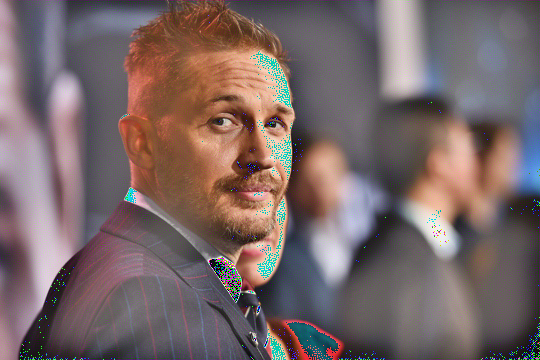

In [181]:
# Conv 2 : 1000 iterations with learning rate = 1000, final loss = 4e-3
res = transforms.ToPILImage()((content_noise_tensor * cnn_normalization_std + cnn_normalization_mean).squeeze(0))
res.save("data/conv2_reconstruction.png")
res

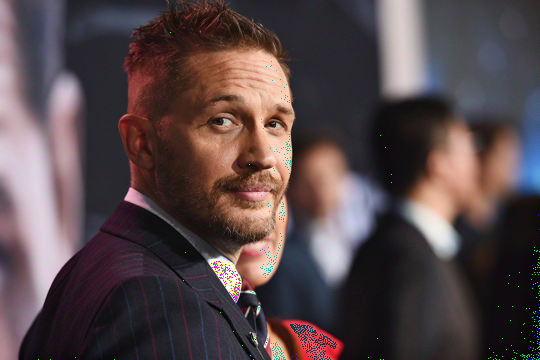

In [175]:
# Conv 1 : 500 iterations with learning rate = 10000, final loss = 1.2e-3
res = transforms.ToPILImage()((content_noise_tensor * cnn_normalization_std + cnn_normalization_mean).squeeze(0))
res.save("data/conv1_reconstruction.png")
res